# Price Data Download Notebook

In [1]:
import os
from datetime import datetime

import yfinance as yf
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Literal
from tqdm import tqdm
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import src.utils.file_management as filemgmt
import src.pipeline.preprocessing as preprocessing

In [2]:
ROOT = Path().resolve().parent
DATA = ROOT / "data"
DAILY_PRICES = DATA / "daily_price_downloads"
MINUTELY_PRICES = DATA / "minutely_price_downloads"
INTERPOLATED_PRICES = DATA / "interpolated_prices"
SAVED_MODELS = DATA / "saved_models"

AV_API_KEY_FILE = ROOT / "private" / "Alpha Vantage API Key.txt"
with open(AV_API_KEY_FILE) as file: AV_API_KEY = file.read()


## Download from AlphaVantage
(Restricted to 25 daily free requests)

### Execution

In [45]:
frame = preprocessing.get_data_from_alphavantage(AV_API_KEY,
                                                 save_path=MINUTELY_PRICES,
                                                 start_year_month=(2025, 5),
                                                 end_year_month=(2025, 6),
                                                 csv_path_to_concat=MINUTELY_PRICES,
                                                 time_increment='6h')
frame

Will query the AlphaVantage API 2 times based on the specified time range. Queries:
 ['2025-05', '2025-06']


ValueError: Provided directory is empty!

## Interpolation

In [69]:
# date import parameters:
date_column = 'date'
price_column = '4. close'
lateset_file_path = filemgmt.most_recent_file(MINUTELY_PRICES, ".csv", "DAX")

# interpolation parameters:
sampling_rate_to_be_interpolated = '7d'
manual_operating_hours = (8, 22)
custom_start_hour = 16
custom_start_minute = 0

interpolated_prices = preprocessing.time_interpolation_new_sampling_rate(df=pd.read_csv(lateset_file_path),
                                                                         interpolation_column=price_column,
                                                                         datetime_column=date_column,
                                                                         new_sampling_rate=sampling_rate_to_be_interpolated,
                                                                         custom_start_hour=custom_start_hour,
                                                                         custom_start_minute=custom_start_minute,
                                                                         verbose=True,
                                                                         manual_operating_hours=manual_operating_hours,
                                                                         save_path=INTERPOLATED_PRICES,
                                                                         save_title_identifier='DAX Close')
interpolated_prices

Excluded every entry on Saturday or Sunday.
Excluded every entry before hour 8 and after hour 22.
New sampling rate (7d) is higher than current lowest time unit (1min).
Therefore some existing indices will be removed to match the new sampling rate, while all information will be kept through the interpolation procedure.


,close
date,
2014-10-23 16:00:00,19.859246
2014-10-30 16:00:00,20.091760
2014-11-06 16:00:00,20.223222
2014-11-13 16:00:00,20.124641
2014-11-20 16:00:00,20.842549
...,...
2025-05-01 16:00:00,41.740000
2025-05-08 16:00:00,42.600000
2025-05-15 16:00:00,42.673310


In [19]:
def print_time_index_entries_p_day(df: pd.DataFrame) -> None:
    df = df.copy()
    df['counter'] = 1
    statistics = df.counter.groupby(by=[df.index.year, df.index.day_of_year]).sum().describe()
    print('Average entries p. day:\t\t\t\t\t', statistics['mean'])
    print('Min. entries p. day:\t\t\t\t\t', statistics['min'])
    print('Lowest 25% entries p. day are below:\t', statistics['25%'])
    print('Lowest 50% entries p. day are below:\t', statistics['50%'])
    print('Lowest 75% entries p. day are below:\t', statistics['75%'])
    print('Max. entries p. day:\t\t\t\t\t', statistics['max'])


# interesting statistics to decide the sampling rate:    
print_time_index_entries_p_day(interpolated_prices)

Average entries p. day:					 55.985063752276865
Min. entries p. day:					 24.0
Lowest 25% entries p. day are below:	 56.0
Lowest 50% entries p. day are below:	 56.0
Lowest 75% entries p. day are below:	 56.0
Max. entries p. day:					 56.0


## ETF - Index Price Relation
Download last interpolated prices and compute relation between ETF and index. **Issue:** ETF notates in US-$, index in EUR...

In [3]:
dax_etf_prices = pd.read_csv(filemgmt.most_recent_file(INTERPOLATED_PRICES, ".csv", "15min"))
dax_etf_prices['date'] = pd.to_datetime(dax_etf_prices.date)
dax_etf_prices.set_index('date', inplace=True)
dax_etf_prices

,close
date,
2014-10-23 16:00:00,19.859246
2014-10-23 16:15:00,19.869064
2014-10-23 16:30:00,19.883171
2014-10-23 16:45:00,19.897279
2014-10-23 17:00:00,19.908301
...,...
2025-06-04 20:45:00,44.849950
2025-06-04 21:00:00,44.790000
2025-06-04 21:15:00,44.780000


In [4]:
dates = ['2025-06-04 18:00:00',     '2025-06-02 17:00:00',  '2025-06-03 12:00:00',  '2025-05-30 17:00:00']
prices = [24276.48,                 23942.52,               23962.40,               23997.71]

In [5]:
multipliers = [price / dax_etf_prices.loc[date, 'close'] for price, date in zip(prices, dates)]
relations = pd.Series(index=dates, data=multipliers, name='Index Multiplier').sort_index()
relations

2025-05-30 17:00:00    545.401260
2025-06-02 17:00:00    541.012767
2025-06-03 12:00:00    544.569059
2025-06-04 18:00:00    542.248827
Name: Index Multiplier, dtype: float64

## Future Price Simulation

In [7]:
class FutureProduct:
    """ Models the price evolution of a future financial product. """
    def __init__(self,
                 underlying_price_series: pd.Series,
                 risk_premium: float,
                 date_base_price_tuple: (str, float),
                 date_base_price_tuple2: (str, float) = None,
                 historic_date_future_price_tuple: (str, float) = None,
                 subscription_ratio: float = 1,
                 issue_date: str = None,
                 ):
        """
        Class for modeling the price evolution of a future financial product 
        based on an underlying asset, accounting for base price changes and 
        financing costs over time.
    
        The class computes a base price series, intrinsic value, and final 
        price of a future product, given a time series of underlying prices 
        and one or two calibration points. If two base prices or a historical 
        future price are provided, it estimates the time-varying base price 
        through linear interpolation.
    
        Parameters
        ----------
        underlying_price_series : pd.Series
            Time series of the underlying asset prices. Must have a DateTimeIndex.
        risk_premium : float
            Constant premium added to the intrinsic value to compute the product price.
        date_base_price_tuple : (str, float)
            A tuple containing a date and the corresponding base price.
        date_base_price_tuple2 : (str, float), optional
            A second base price tuple (date and value) for interpolation.
        historic_date_future_price_tuple : (str, float), optional
            A tuple containing a past date and the future price at that date. 
            Used to back-calculate a second base price (overwrites `date_base_price_tuple2`).
        subscription_ratio : float, default 1
            Scaling factor that links changes in the underlying asset to the 
            product's intrinsic value.
        issue_date : str, optional
            If provided, trims all data before this date in the underlying series.
        """
        # convert underlying price array to pd.Series with DatetimeIndex:
        self.underlying_price_series = underlying_price_series if isinstance(underlying_price_series, pd.Series) else pd.Series(underlying_price_series.iloc[:, 0])
        self.underlying_price_series.index = pd.to_datetime(underlying_price_series.index)
        
        self.risk_premium = risk_premium
        self._date_base_price_tuple = date_base_price_tuple  # will be accessible through properties with setter for recalculation of base-price series
        self._date_base_price_tuple2 = date_base_price_tuple2
        self._historic_date_future_price_tuple = historic_date_future_price_tuple
        self.subscription_ratio = subscription_ratio
        
        # consider issue date:
        self.issue_date = issue_date
        if self.issue_date is not None:
            if self.underlying_price_series.index.min() < pd.Timestamp(self.issue_date):
                self.underlying_price_series = self.underlying_price_series[self.issue_date:]
        
        # private attributes for properties:
        self._base_price_series = self._intrinsic_value_series = None
        
        # if provided, overwrite 2nd base price:
        if historic_date_future_price_tuple is not None: self.get_historic_base_price(date=historic_date_future_price_tuple[0],
                                                                                      future_price=historic_date_future_price_tuple[1],
                                                                                      use_as_2nd_base_price_tuple=True)
    
    def get_historic_base_price(self, date: str, future_price: float, use_as_2nd_base_price_tuple=False):
        """
        Compute the historic base price from a given past future price.

        Parameters
        ----------
        date : str
            Date of the historical future price.
        future_price : float
            Value of the future product on the given date.
        use_as_2nd_base_price_tuple : bool, default False
            If True, sets the computed base price as the second calibration point.

        Returns
        -------
        float
            The computed historic base price.
        """
        date = pd.Timestamp(date)
        if date.hour == 0: date = date.replace(hour=10)  # prevent errors if no hour was provided
        if self.direction == "long":
            base_price = (self.risk_premium - future_price) / self.subscription_ratio + self.underlying_price_series[date]
        else:  # for short
            base_price = (future_price - self.risk_premium) / self.subscription_ratio + self.underlying_price_series[date]
        
        # eventually rewrite 2nd base price tuple for recalculation of base price series:
        if use_as_2nd_base_price_tuple: self.date_base_price_tuple2 = (date, base_price)
        
        return base_price
    
    def plot(self, plot_size = (10,10), leverage_lim=[1, 5]) -> None:
        """ Plot price and leverage development. """
        fig, (ax, ax3) = plt.subplots(2, 1, figsize=plot_size)
        ax2 = ax.twinx()
        ax.plot(self.date_index, self.underlying_price_series, color='blue', label='Underlying Price')
        ax.plot(self.date_index, self.base_price_series, color='black', label='Base Price')
        ax2.plot(self.date_index, self.price_series, color='green', label='Future Price')
        ax.set_ylabel('Price [€]')
        ax2.set_ylabel('Price [€]')
        
        # plot leverage:
        ax3.plot(self.date_index, self.leverage_series, color='red', label='Leverage')
        ax.legend(loc='upper left'); ax2.legend(loc='lower right')
        ax3.set_ylabel('Leverage [x]')
        ax3.set_xlabel('Date')
        ax3.set_ylim(leverage_lim)
        ax.grid(color='grey')
        ax2.grid(axis='y', color='lightgrey')
        ax3.grid()
        fig.tight_layout()
    
    ### Base price properties ###
    @property
    def date_base_price_tuple(self):
        """
        The primary base price calibration point.

        Returns
        -------
        tuple
            A tuple containing a date and corresponding base price.
        """
        return self._date_base_price_tuple
    @date_base_price_tuple.setter
    def date_base_price_tuple(self, value):
        """ Setting attribute triggers re-computation of base_price_series """
        self._date_base_price_tuple = value
        self._base_price_series = None
        
    @property
    def date_base_price_tuple2(self):
        """
        The secondary base price calibration point.

        Returns
        -------
        tuple
            A tuple containing a date and corresponding base price.
        """
        return self._date_base_price_tuple2
    @date_base_price_tuple2.setter
    def date_base_price_tuple2(self, value):
        """ Setting attribute triggers re-computation of base_price_series """
        self._date_base_price_tuple2 = value
        self._base_price_series = None
        
    @property
    def historic_base_price(self):
        """
        Tuple of (date, future price) used to compute a historical base price.

        Returns
        -------
        tuple
            A tuple of (date, future product price).
        """
        return self._historic_date_future_price_tuple
    @historic_base_price.setter
    def historic_base_price(self, value):
        """ Setting attribute triggers re-computation of base_price_series """
        self._historic_date_future_price_tuple = value
        self._base_price_series = None
    
    @property
    def base_price_series(self):
        """
        Time series of the interpolated base price used for pricing the future product.

        Returns
        -------
        pd.Series
            Interpolated base price series indexed by date.
        """
        if self._base_price_series is None:  # linear interpolation for base price calculation
            # get integer positions in date_index:
            if self.date_base_price_tuple2 is not None:
                provided_dates = [self.date_index.get_loc(date) for date in
                                  [self.date_base_price_tuple[0], self.date_base_price_tuple2[0]]]
                provided_prices = [self.date_base_price_tuple[1], self.date_base_price_tuple2[1]]
        
                # do interpolation and safe series:
                self._base_price_series = pd.Series(index=self.date_index,
                                                    # we use scipy interpolate because this extrapolates linear trends beyond provided data points:
                                                    data=interp1d(provided_dates, provided_prices, kind='linear',
                                                                  fill_value='extrapolate')(  # interp1d object has to be called with integer indices
                                                        range(0, len(self.date_index))),
                                                    name='base_price_series'
                                                    )
            else:
                self._base_price_series = pd.Series(index=self.date_index, name='base_price_series')
                self._base_price_series.iloc[:]= self.date_base_price_tuple[1]
            
        return self._base_price_series
    
    ### General properties ###
    @property
    def direction(self) -> Literal['long', 'short']:
        """
        Indicates whether the product is currently 'long' or 'short' based on final values.

        Returns
        -------
        str
            'long' if underlying > base price, 'short' if underlying < base price.
        """
        if self.underlying_price_series.iloc[-1] > self.base_price_series.iloc[-1]: return 'long'
        elif self.underlying_price_series.iloc[-1] < self.base_price_series.iloc[-1]: return 'short'
    
    @property
    def leverage_series(self) -> pd.Series:
        """
        Time series representing the leverage ratio of the product.

        Returns
        -------
        pd.Series
            Leverage values computed daily.
        """
        return pd.Series(index=self.date_index,
                         # numpy to accelerate computation:
                         data=np.array(self.underlying_price_series) * self.subscription_ratio / np.array(self.price_series),
                         name='Leverage')
    
    @property
    def date_index(self):
        """
        Returns the index of the underlying time series.

        Returns
        -------
        pd.DatetimeIndex
            Dates associated with the underlying prices.
        """
        return self.underlying_price_series.index
    
    ### Price calculation ###
    @property
    def intrinsic_value_series(self):
        """
        Time series of the product's intrinsic value, which is 
        (underlying - base price) * subscription ratio.

        Returns
        -------
        pd.Series
            Intrinsic value per date.
        """
        return pd.Series(index=self.date_index,
                         # numpy to accelerate computation:
                         data=np.abs(np.array(self.underlying_price_series) - np.array(self.base_price_series)) * self.subscription_ratio,
                         name='Intrinsic Value')
    
    @property
    def price_series(self):
        """
        Full price series of the future product, incorporating 
        intrinsic value and constant risk premium.

        Returns
        -------
        pd.Series
            Final product prices over time.
        """
        return pd.Series(index=self.date_index,
                         # numpy to accelerate computation:
                         data=np.array(self.intrinsic_value_series) + self.risk_premium,
                         name='Future Price')

long


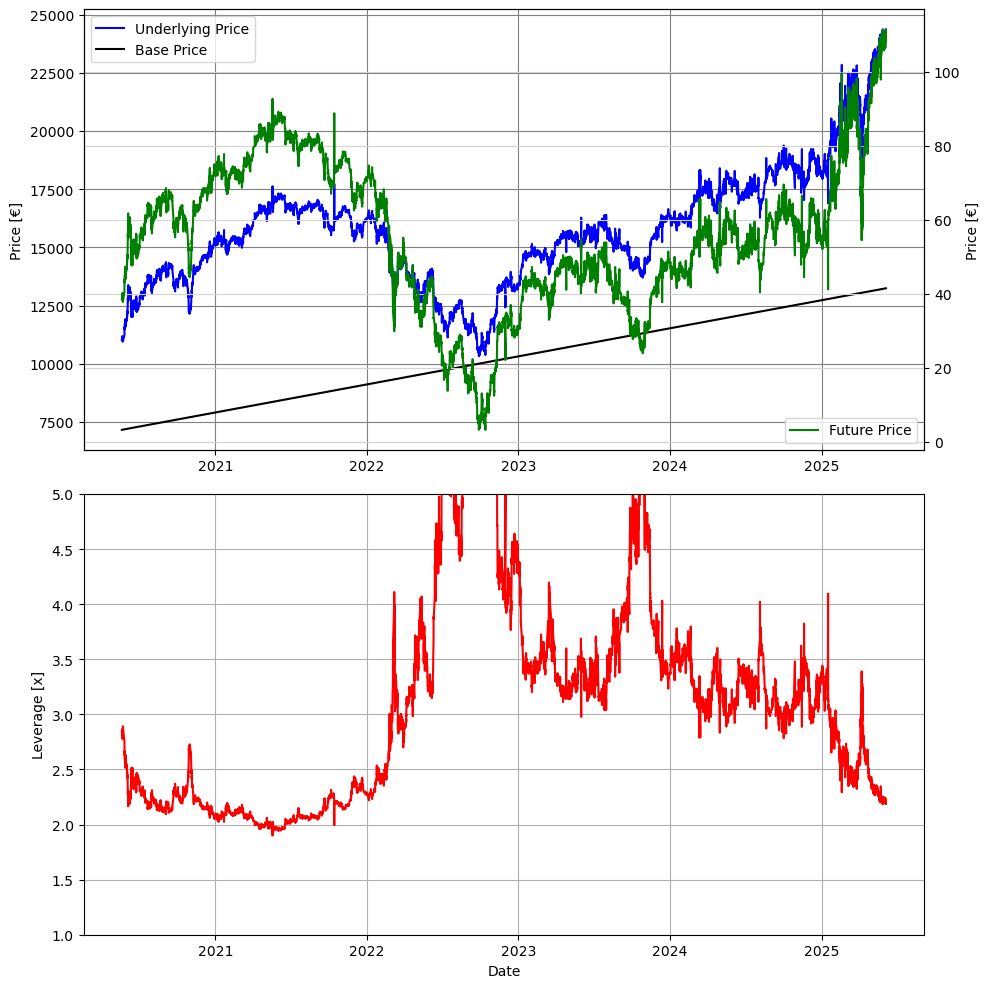

In [8]:
dax_long = FutureProduct(dax_etf_prices['close'] * relations.mean(),
                         risk_premium=0.0930,
                         date_base_price_tuple=("2025-06-04 18:00:00", 13240.2984),
                         historic_date_future_price_tuple=("2022-09-26", 6.49),
                         subscription_ratio=0.01,
                         issue_date='2020-05-20', )
dax_long.plot()
print(dax_long.direction)

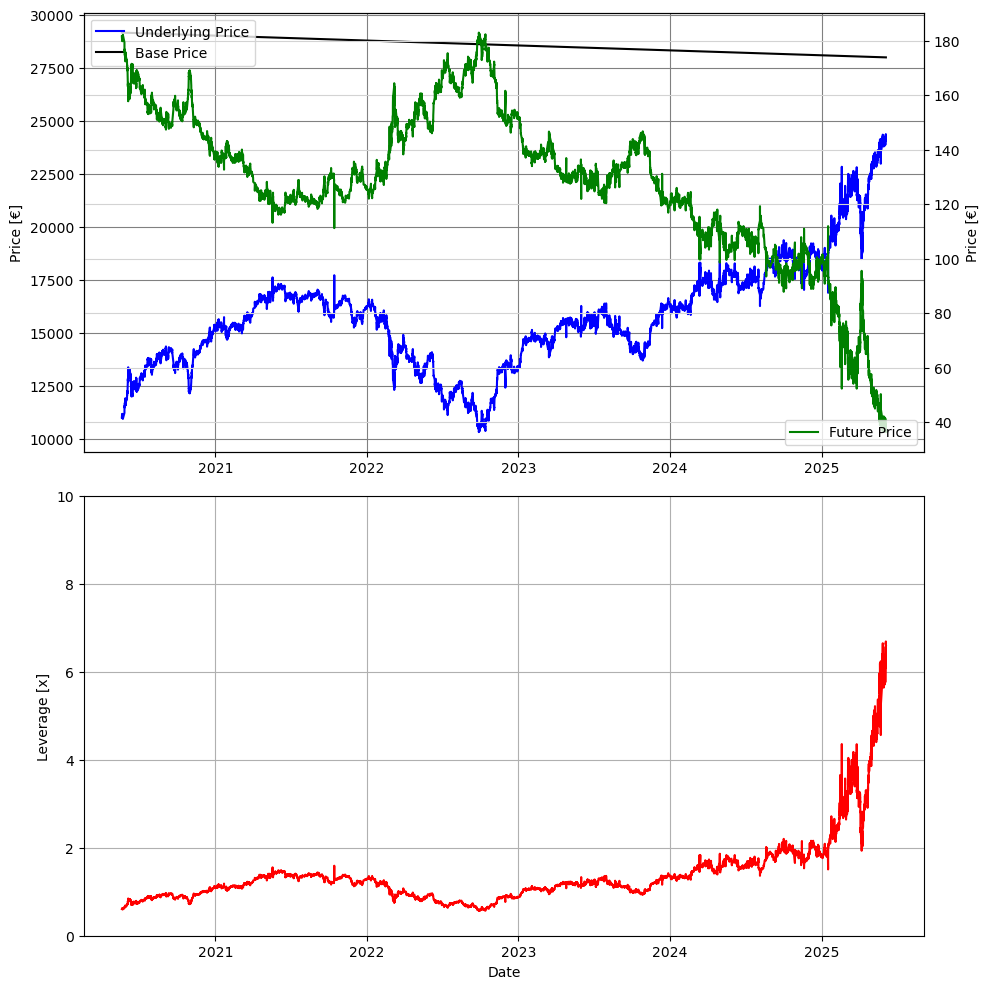

In [24]:
dax_short = FutureProduct(dax_etf_prices['close'] * relations.mean(),
                         risk_premium=0.0930,
                         date_base_price_tuple=("2025-06-04 18:00:00", 28000),
                         historic_date_future_price_tuple=("2022-09-26", 180),
                         subscription_ratio=0.01,
                         issue_date='2020-05-20',)
dax_short.plot(leverage_lim=(0, 10))

### Automatischer Produktinfo Scrape
Link bspw: https://www.boerse-frankfurt.de/zertifikat/de000tt2ch77-open-end-turbo-auf-dax/stammdaten

- risk_premium: Aufgeld absolut
- base_price: Basispreis
- subscription_ratio: Bezugsverhältnis
- issue_date: Ausgabedatum